# 1. Import Libraries

In [60]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer,PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# 2. Load Dataset

In [61]:
df = pd.read_csv('stroke.csv')

In [62]:
print(df.columns)

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')


# 3. Data Cleaning

In [63]:
# Drop specified columns, duplicates, and NaN values
df = df.drop(columns=['id', 'Residence_type', 'gender'])
df = df.dropna()
df = df.drop_duplicates()

print(f"Dataset shape after cleaning: {df.shape}")

Dataset shape after cleaning: (4909, 9)


# 4. Merge Work Types and Encode Married

In [64]:
# Merge children and Never_worked categories
df['work_type'] = df['work_type'].replace({
    'children': 'Child_Neverwork',
    'Never_worked': 'Child_Neverwork'
})

# Binary encode ever_married: Yes=1, No=0
df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No': 0})

print("Unique work types after merging:", df['work_type'].unique())
print("ever_married unique values after encoding:", df['ever_married'].unique())

Unique work types after merging: ['Private' 'Self-employed' 'Govt_job' 'Child_Neverwork']
ever_married unique values after encoding: [1 0]


# 5. Feature Engineering

In [65]:
# Create interaction features
df['age_glucose_interaction'] = df['age'] * df['avg_glucose_level']
df['age_bmi_interaction'] = df['age'] * df['bmi']

# Create high risk feature
df['high_risk'] = ((df['hypertension'] == 1) | (df['heart_disease'] == 1)).astype(int)

print("New features added:")
for col in ['age_glucose_interaction', 'age_bmi_interaction', 'high_risk']:
    print(f"{col}: range [{df[col].min():.2f}, {df[col].max():.2f}]")

New features added:
age_glucose_interaction: range [5.63, 20770.40]
age_bmi_interaction: range [1.13, 4040.40]
high_risk: range [0.00, 1.00]


# 6. Data Splitting

In [66]:
RANDOM_STATE = 42

# Features and target
X = df.drop(columns=['stroke'])
y = df['stroke']

# First split: separate test set (20% of data)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Second split: divide remaining data into train and validation (80% train, 20% validation of remaining data)
# This gives us 64% train, 16% validation of the total data
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=RANDOM_STATE
)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")
print("\nClass distribution:")
print(f"Train - Stroke rate: {y_train.mean():.3f}")
print(f"Validation - Stroke rate: {y_val.mean():.3f}")
print(f"Test - Stroke rate: {y_test.mean():.3f}")

Train: (3141, 11), Validation: (786, 11), Test: (982, 11)

Class distribution:
Train - Stroke rate: 0.043
Validation - Stroke rate: 0.042
Test - Stroke rate: 0.043


# 7. Target Encoding Setup

In [67]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class StrokeRateEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_cols=None):
        self.categorical_cols = ['work_type', 'smoking_status']
        self.encoding_dict = {}

    def fit(self, X, y):
        for col in self.categorical_cols:
            self.encoding_dict[col] = y.groupby(X[col]).mean().to_dict()
        return self

    def transform(self, X):
        X_encoded = X.copy()
        for col in self.categorical_cols:
            mean_val = np.mean(list(self.encoding_dict[col].values()))
            X_encoded[col] = X[col].map(self.encoding_dict[col]).fillna(mean_val)
        return X_encoded

# 8. Create and Configure Pipeline

In [68]:
pipe = ImbPipeline([
    ('target_encoder', StrokeRateEncoder()),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', LogisticRegression(
        C=0.1,
        penalty='l2',
        solver='lbfgs',
        class_weight='balanced',
        max_iter=200,
        random_state=RANDOM_STATE
    ))
])

# 9. Fit Pipeline

In [69]:
# Fit the pipeline on training data
pipe.fit(X_train, y_train)

,steps,"[('target_encoder', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,categorical_cols,"['work_type', 'smoking_status']"
,copy,True
,with_mean,True
,with_std,True
,sampling_strategy,'auto'
,random_state,42
,k_neighbors,5


# 10. Evaluate

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report, confusion_matrix, roc_curve
import numpy as np

def evaluate_split(y_true, y_proba, threshold=0.5, name="Split"):
    y_pred = (y_proba >= threshold).astype(int)
    roc_auc = roc_auc_score(y_true, y_proba)
    prec, rec, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(rec, prec)
    print(f"\n=== {name} ===")
    print(f"Threshold={threshold:.2f}, ROC-AUC={roc_auc:.4f}, PR-AUC={pr_auc:.4f}")
    print(classification_report(y_true, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stroke', 'Stroke'],
                yticklabels=['No Stroke', 'Stroke'])
    plt.title(f"Confusion Matrix - {name} (thr={threshold:.2f})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC={roc_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

In [71]:
def plot_prob_distributions(y_true, y_proba, threshold=0.5):
    no_stroke_probs = y_proba[y_true == 0]
    stroke_probs = y_proba[y_true == 1]

    no_stroke_pred_below_thr = no_stroke_probs[no_stroke_probs < threshold]
    no_stroke_pred_above_thr = no_stroke_probs[no_stroke_probs >= threshold]
    stroke_pred_below_thr = stroke_probs[stroke_probs < threshold]
    stroke_pred_above_thr = stroke_probs[stroke_probs >= threshold]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    bins = np.linspace(0, 1, 30)

    sns.histplot(no_stroke_pred_below_thr, bins=bins, color='blue', label='TN', ax=axes[0], alpha=0.7)
    sns.histplot(no_stroke_pred_above_thr, bins=bins, color='red', label='FP', ax=axes[0], alpha=0.7)
    axes[0].axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.2f}')
    axes[0].set_xlim(0, 1)
    axes[0].set_title('Predicted Probabilities for True No Stroke Cases')
    axes[0].set_xlabel('Predicted Probability of Stroke')
    axes[0].set_ylabel('Count')
    axes[0].legend()

    sns.histplot(stroke_pred_below_thr, bins=bins, color='red', label='FN', ax=axes[1], alpha=0.7)
    sns.histplot(stroke_pred_above_thr, bins=bins, color='blue', label='TP', ax=axes[1], alpha=0.7)
    axes[1].axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.2f}')
    axes[1].set_xlim(0, 1)
    axes[1].set_title('Predicted Probabilities for True Stroke Cases')
    axes[1].set_xlabel('Predicted Probability of Stroke')
    axes[1].set_ylabel('Count')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


In [72]:
# Predict probabilities for validation and test sets
val_proba = pipe.predict_proba(X_val)[:, 1]
test_proba = pipe.predict_proba(X_test)[:, 1]

Validation Set:

=== Validation ===
Threshold=0.30, ROC-AUC=0.8563, PR-AUC=0.1440
              precision    recall  f1-score   support

           0     0.9978    0.6096    0.7568       753
           1     0.0982    0.9697    0.1783        33

    accuracy                         0.6247       786
   macro avg     0.5480    0.7896    0.4675       786
weighted avg     0.9601    0.6247    0.7325       786



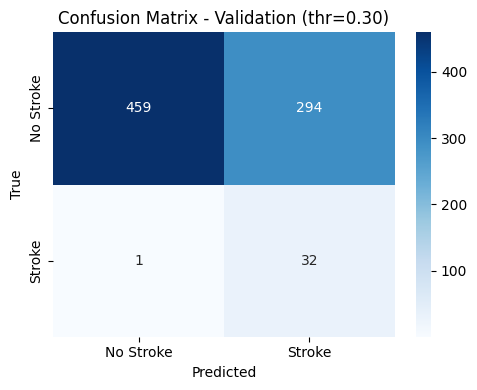

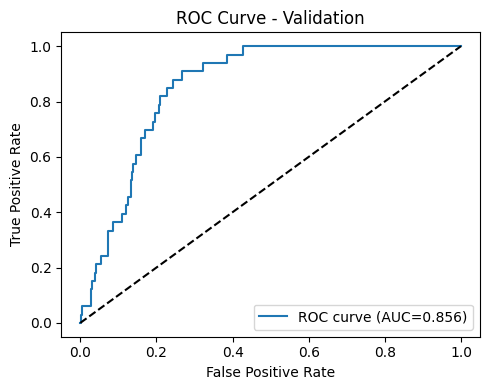

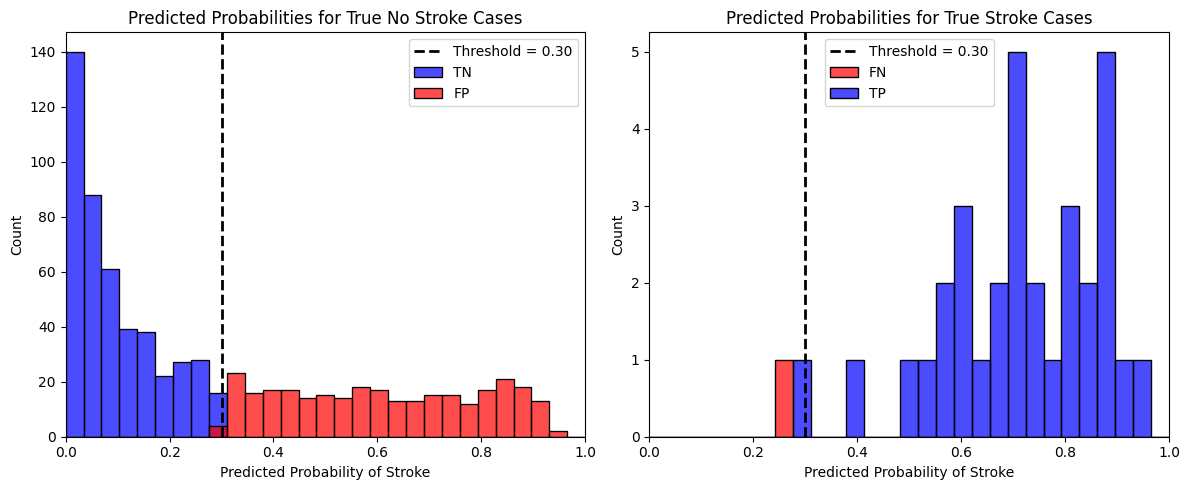

In [73]:
# Run evaluation and plot for validation set
print('Validation Set:')
evaluate_split(y_val, val_proba, threshold=0.3, name="Validation")
plot_prob_distributions(y_val, val_proba, threshold=0.3)

Test Set:

=== Test ===
Threshold=0.30, ROC-AUC=0.8116, PR-AUC=0.1856
              precision    recall  f1-score   support

           0     0.9900    0.6319    0.7714       940
           1     0.0942    0.8571    0.1698        42

    accuracy                         0.6415       982
   macro avg     0.5421    0.7445    0.4706       982
weighted avg     0.9517    0.6415    0.7457       982



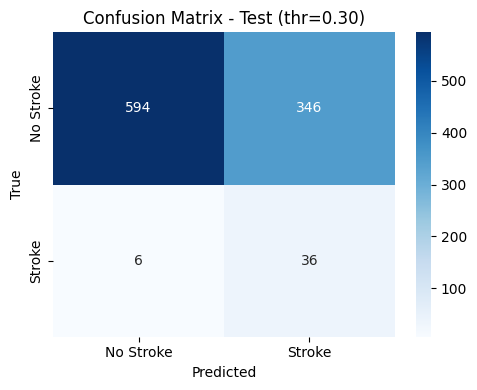

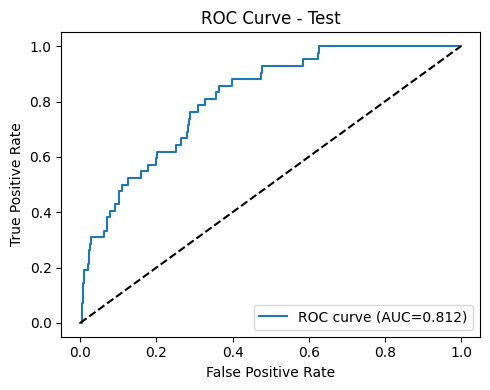

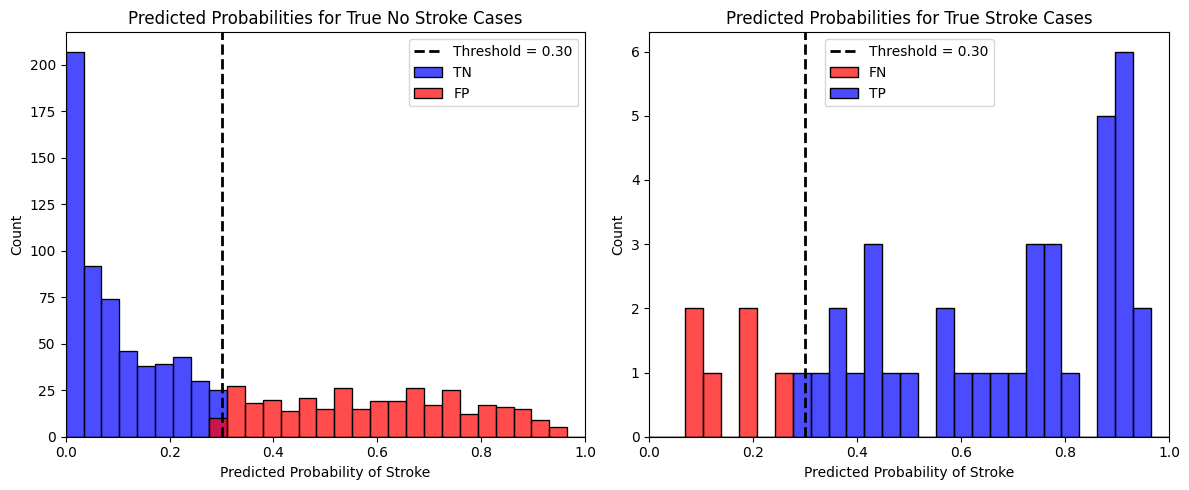

In [74]:
# Run evaluation and plot for test set
print('Test Set:')
evaluate_split(y_test, test_proba, threshold=0.3, name="Test")
plot_prob_distributions(y_test, test_proba, threshold=0.3)

# 11. Final Model Evaluation (Training on Combined Data)

Final Test Set Evaluation:

=== Test ===
Threshold=0.30, ROC-AUC=0.8137, PR-AUC=0.2185
              precision    recall  f1-score   support

           0     0.9917    0.6362    0.7751       940
           1     0.0976    0.8810    0.1758        42

    accuracy                         0.6466       982
   macro avg     0.5447    0.7586    0.4754       982
weighted avg     0.9535    0.6466    0.7495       982



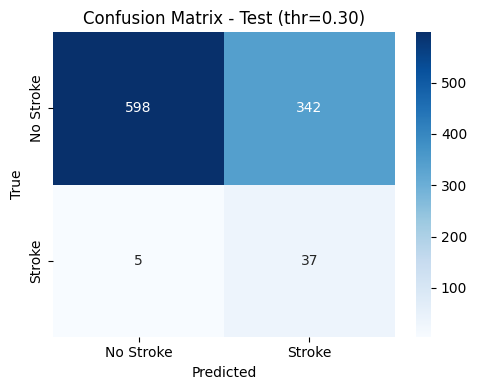

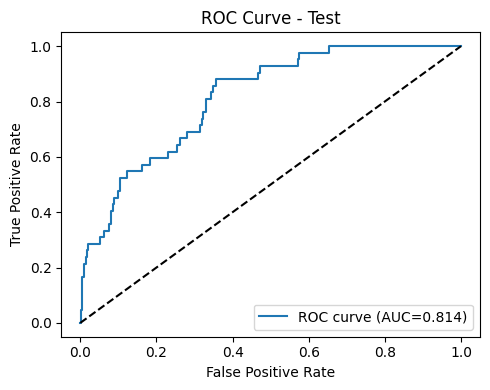

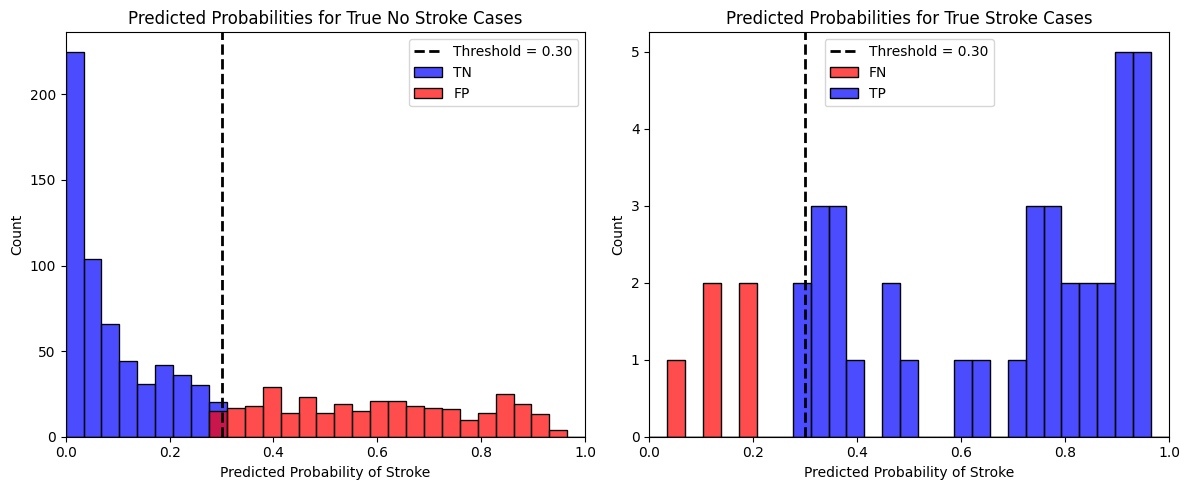

In [75]:
# Combine train and validation sets
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# Retrain the pipeline on combined data
pipe.fit(X_train_full, y_train_full)

# Get predictions on test set
test_proba = pipe.predict_proba(X_test)[:, 1]

# Evaluate on test set
print('Final Test Set Evaluation:')
evaluate_split(y_test, test_proba, threshold=0.3, name="Test")
plot_prob_distributions(y_test, test_proba, threshold=0.3)

In [76]:
import cloudpickle

with open("stroke_rate_logistic.pkl", "wb") as f:
    cloudpickle.dump(pipe, f)

In [77]:
with open("stroke_rate_logistic.pkl", "rb") as f:
    loaded_model = cloudpickle.load(f)

Loaded Model Test Set Evaluation:

=== Test (Loaded Model) ===
Threshold=0.30, ROC-AUC=0.8137, PR-AUC=0.2185
              precision    recall  f1-score   support

           0     0.9917    0.6362    0.7751       940
           1     0.0976    0.8810    0.1758        42

    accuracy                         0.6466       982
   macro avg     0.5447    0.7586    0.4754       982
weighted avg     0.9535    0.6466    0.7495       982



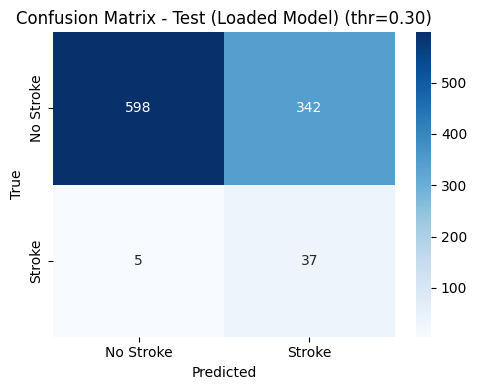

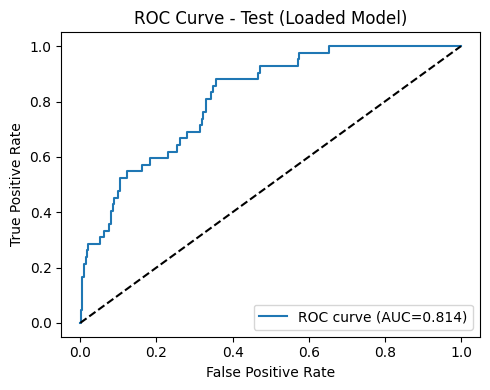

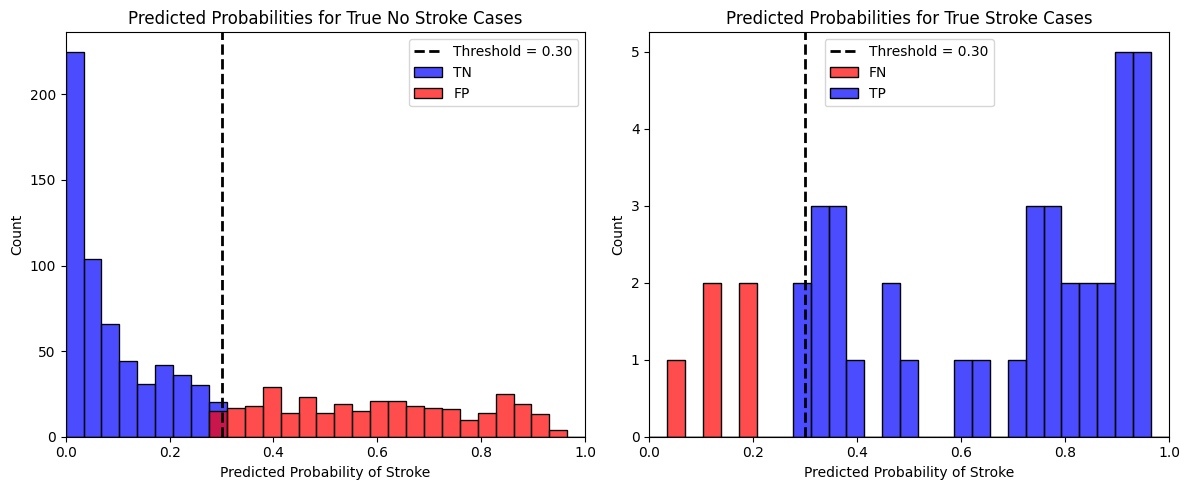


Verification of Model Loading:
Maximum difference in predictions: 0.0000000000
Models are identical:


In [78]:
loaded_test_proba = loaded_model.predict_proba(X_test)[:, 1]

# Evaluate on test set
print('Loaded Model Test Set Evaluation:')
evaluate_split(y_test, loaded_test_proba, threshold=0.3, name="Test (Loaded Model)")
plot_prob_distributions(y_test, loaded_test_proba, threshold=0.3)

# Verify that predictions match with original model
original_predictions = test_proba
loaded_predictions = loaded_test_proba

print("\nVerification of Model Loading:")
print(f"Maximum difference in predictions: {np.max(np.abs(original_predictions - loaded_predictions)):.10f}")
print("Models are identical:" if np.allclose(original_predictions, loaded_predictions) else "Warning: Models differ!")

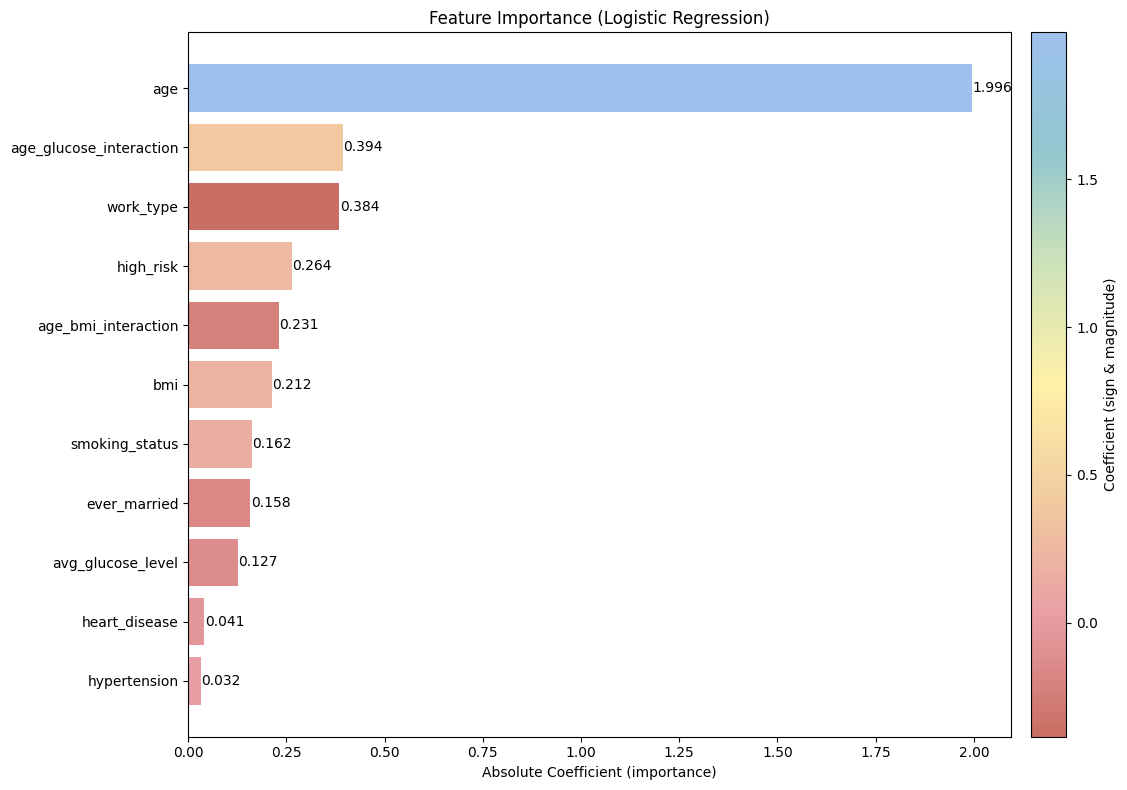

In [84]:
import seaborn as sns

import matplotlib.pyplot as plt

# Get feature names and coefficients
feature_names = X_train.columns
coefficients = pipe.named_steps['classifier'].coef_[0]

# Create dataframe with sign-aware importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coef': coefficients,
    'Importance': np.abs(coefficients)
})

# Sort by absolute importance (descending for plotting)
feature_importance = feature_importance.sort_values('Importance', ascending=True)

# Map coefficients to colors using a sunlight (yellow->orange->red) colormap
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
norm = plt.Normalize(vmin=feature_importance['Coef'].min(), vmax=feature_importance['Coef'].max())
# palette matching the user's pastel warm-to-cool blocks
sun_colors = ['#c96e63', '#e79da3', '#f1caa0', '#fff1a8', '#cfe3b8', '#93c6cf', '#9ec1ee']
cmap = LinearSegmentedColormap.from_list('sunlight', sun_colors)
colors = [cmap(norm(v)) for v in feature_importance['Coef']]

# Plot horizontal bar chart with diverging colors
plt.figure(figsize=(12, 8))
bars = plt.barh(feature_importance['Feature'], feature_importance['Importance'], color=colors)
plt.xlabel('Absolute Coefficient (importance)')
plt.title('Feature Importance (Logistic Regression)')

# Colorbar indicating sign and magnitude
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
# provide the actual coefficient values so the mappable has data
sm.set_array(feature_importance['Coef'])
ax = plt.gca()
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Coefficient (sign & magnitude)')

# Add value labels on the bars
for bar, val in zip(bars, feature_importance['Importance']):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, f'{val:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()